In [11]:
#installs packages, sets up the environment
#you only need to run this once 
#a notebook cell with ! allows you to run a terminal/command-line command
%pip install yfinance pandas numpy scikit-learn matplotlib seaborn
#yfinance --> Gets stock prices by dowloading OHLCV from Yahoo's finance API
#pandas --> data manipulation library in Python 
#       --> joining datasets 
#       --> filtering rows/columns
#       --> computing rolling windows like moving averages and volatility
#       --> date/time indexing
#numpy --> numerical computing like arrays, vectorized math, fast calculations, log returns, matrix operations
#scikit-learn --> ml python library. Has premade models for Linear regression, Lasso(?) Training, test splitting(?), scalers(?), model evaluation metrics
#matplotlib --> library for creating plots and visualizations 
#seaborn --> built on top of matplotlib but makes prettier statistical plots 

Note: you may need to restart the kernel to use updated packages.


In [12]:
#import libraries

import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib.pyplot as plt
#LinearRegression --> creats a simple linear model y = a +bX for predictin continuous numbers
#Ridge --> Same as LinearRegression but includes a penalty to prevent overfitting (useful for noisy data, correlated features, too many features)
from sklearn.preprocessing import StandardScaler
#StadardScaler --> standardized your features so they have mean = 0, and Standard Deviation = 1
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#mean_squared_error(MSE) --> measures average squared difference between predictied and true values
#mean_absolute_error --> measufres average absolute difference, treats all errors equally
#r2_score --> measures how well your model explains the variance in the data (?)
#         --> ranges from negative infinity to 1, higher is better


In [3]:
#download BITB data 

ticker = "BITB"
#stores the ETF's ticker symbol as a variable

df = yf.Ticker(ticker).history(period="max")
#yf.Ticker(ticker) --> creates a ticker object for BITB (yf = yfinance)
#history(period="max") --> downloads historical price data for as long as this ETF has existed
#this will return a panda Dataframe with all the data columns 

df = df[['Open','High','Low','Close','Volume']].copy()
#this changes the returned value of df (the panda dataframe) to be a dataframe with only the columns we care abour 
#the .copy() avoids warning messages by making a clean copy

df.head() 
#this will show the first few rows of the DataFrame

,Open,High,Low,Close,Volume
Date,,,,,
2024-01-11 00:00:00-05:00,26.799999,28.500000,25.41,25.540001,4781900
2024-01-12 00:00:00-05:00,25.530001,25.530001,23.82,23.959999,3270000
2024-01-16 00:00:00-05:00,23.770000,23.872999,23.02,23.719999,2224500
2024-01-17 00:00:00-05:00,23.520000,23.580000,23.08,23.400000,1956000
2024-01-18 00:00:00-05:00,23.400000,23.400000,22.23,22.340000,2856900


In [13]:
#compute daily returns

df['return'] = df['Close'].pct_change() 
#this will create a new column in the dataframe called 'return'
#'return' will contain the day-to-day percentage change in the close price 
#return = (close_x - close_(x-1)) / (close x-1) 
#       = (close_x / close_(x-1)) -1 
#the values returned will be fractions (to have it formated as a percentage multiply by 100)
#the very first row will be NaN because there's no previous day to compare to

df = df.dropna()
#this will remove all rows that contain NaN in any column (like the first row)
#this is because machines learniing models and many operations expect no missing values
#NaN may appear in this project due to missing prices, holidays, etc.

df['return'].describe()
#this will produce summary statistics for the return column 
#    --> count(num of non-NaN observations), max/min(worst and best one day returns), std(volatility), 25%/50%/75%(meadian and quartiles), mean (average daily return), name, and dtype 


count    485.000000
mean       0.002088
std        0.031439
min       -0.144157
25%       -0.017389
50%       -0.000356
75%        0.021700
max        0.133397
Name: return, dtype: float64

In [14]:
#Feature Engineering (process of creating, modifying, or selecting input variables in a dataset)
#this cell will create lagged returns(?), moving averages(?), volatility, and volume ratio

#lagging returns

df['r_lag1'] = df['return'].shift(1)
#this will create a new column called "r_lag1"
#we do this because in time series (like stock prices) you want to predict today's returns using past data 
#shift(1) will move everything down by 1 so each rown now contains the previous day's returns 

# moving averages of returns (shifted so they are only info from the past)
df['ma5'] = df['return'].rolling(window=5).mean().shift(1)
df['ma10'] = df['return'].rolling(window=10).mean().shift(1)
#rolling(window=5).mean() --> calculate the average return over the past 5 days 
#shift(1) --> move it down so we only use past data 

# volatility (rolling std)
df['vol5'] = df['return'].rolling(window=5).std().shift(1)
df['vol10'] = df['return'].rolling(window=10).std().shift(1)
#this calculates how much returns fluctaute over the past days. This is a measure of volatility 
#volatility is the degree of variation in the price of an asset or market over time, indicating how quickly and unpredictably its value can change

# volume relative to 10-day average
df['vol_avg10'] = df['Volume'].rolling(window=10).mean().shift(1)
#takes the average trading colyne over the past 10 days 
df['vol_ratio'] = df['Volume'] / df['vol_avg10']
#todays volume divided by the past 10 day average 
#vol_ratio > 1, higher than average trading activity 
#vol_ratio < 1, lower than average trading activity
#this will help indicate trends, news, or unusual market behavior

# Drop rows with NaNs produced by shifting/rolling
df = df.dropna()
df.tail()
#returns the last couple rows of the DataFrame


,Open,High,Low,Close,Volume,return,r_lag1,ma5,ma10,vol5,vol10,vol_avg10,vol_ratio
Date,,,,,,,,,,,,,
2025-12-29 00:00:00-05:00,47.540001,47.880001,47.250000,47.310001,1451100,-0.004838,0.002954,0.007062,-0.004544,0.019400,0.024423,2741810.0,0.529249
2025-12-30 00:00:00-05:00,47.869999,48.580002,47.700001,47.730000,2955200,0.008878,-0.004838,-0.002049,-0.003324,0.004989,0.024031,2653300.0,1.113783
2025-12-31 00:00:00-05:00,48.290001,48.310001,47.320000,47.560001,2615500,-0.003562,0.008878,-0.000984,0.002519,0.006743,0.017851,2644650.0,0.988978
2026-01-02 00:00:00-05:00,48.259998,49.470001,48.049999,48.799999,4693300,0.026072,-0.003562,-0.000196,0.000060,0.005977,0.016673,2490420.0,1.884542
2026-01-05 00:00:00-05:00,50.430000,51.360001,50.195000,51.099998,3672199,0.047131,0.026072,0.005901,0.004685,0.012543,0.016850,2715770.0,1.352176


In [ ]:
#Train-Test Split (time series) 
#in machine learning, we usually split our data into two sets 
#              - traning set: used to train the model 
#              - test set: used to evaluate the model 
#in time series data, there is a time order (past-> present-> future)
#we can't randomly shuffle data because that might make future data leake into the 

train_size = int(len(df) * 0.8)
#len(df)--> counts the number of rows in the DataFrame 
#* .8 will take 80 percent of the rows. That is a common choice for the training set for some reason 
#int() will make sure the result is an integer 

train_df = df.iloc[:train_size]
#selects rows from the start up to (not inlcuding) the index 'train_size'
#this will become the training dataset
#iloc is integer location based indexing, so it slices rows by position, not by label 
#               - iloc stands for integer location 
#               - it lets you selecr rows and columns by their ineteger position, not by their labels
#               - basic syntax --> df.iloc[row_selection, column_selection]

test_df = df.iloc[train_size:]
#this selects rows from train_size to the end
#this becomes the test dataset f

#test_df is the end of the dataset while train_size is the beginning 80% because this is a time series dataset 
#|----------Training----------|----Test----|
#this would mimic how you would make predictions in real life:train in the past, test on the future

In [18]:
#Scale Feautures
from sklearn.preprocessing import StandardScaler
#importing the scaler, StandardScaler is used to standardize features
#Transforms the data so each feature has Mean = 0 & StanDev = 1

features = ["r_lag1", "ma5", "vol10", "vol_ratio"]
#input variables for the input variables for the models 
#   r_lag1 -> prevous return
#   ma5 ->
scaler = StandardScaler()

X_train = scaler.fit_transform(train_df[features])
X_test = scaler.transform(test_df[features])

y_train = train_df["return"].values
y_test = test_df["return"].values


In [ ]:
#Fit the Linear Regression Model

#OLS (Ordinary Least Squares) - What straight line fits my data best
#Teaching a model how to predict returns using past data 
model = LinearRegression() 
#LinearRegression() can't predict anything yet, needs to learn first 
model.fit(X_train, y_train) #where learning happens 
print(X_train)

[[ 1.62481444  2.32483332 -0.61939259  2.19039904]
 [-0.54695524  1.84912628 -0.4507285   1.39320837]
 [ 1.3543506   2.17931186 -0.58933923  2.58066058]
 ...
 [-1.31689169 -0.15883606 -0.75965501 -0.74483616]
 [-0.35567259 -0.14458763 -1.0001888  -0.68456645]
 [-0.26648393 -0.55610495 -1.02051531  0.30300211]]


In [ ]:
#Prediction and Evaluation 
#Checks how good predictions are 
y_pred = model.predict(X_test)
#model.predict(...) uses a learned rule from training 
#X_test is data the model has never seen before 
#y_pred are the predicted returns in list/array format 

mse = mean_squared_error(y_test, y_pred)
#mse is how wrong the predictions are sqaured
#This is done by... 
#   taking actual - predicted 
#   squaring it 
#   taking the average over all days 
#Lower = better 

mae = mean_absolute_error(y_test, y_pred)
#mae is the average size of error 
#This is done by... 
#   taking |actual - predicted|
#   taking the average of this 

r2  = r2_score(y_test, y_pred)
#how much of the variation in returns is explained by model 


dir_acc = (np.sign(y_pred) == np.sign(y_test)).mean()
#directional accuracy 
#np.sign(y_pred)-> converts predictions from (+1, -1, 0) to (positive, negative, or zero)
#ensures directions of returns of predicted data and real data are equal 

#print results
print(f"MSE: {mse:.6e}") #penalizes big erros 
print(f"MAE: {mae:.6e}") #typical prediction error
print(f"R^2: {r2:.4f}") # how much signal captured 
print(f"Directional accuracy: {dir_acc:.3f}") #trading relavance 



MSE: 6.971367e-04
MAE: 2.201815e-02
R^2: 0.0159
Directional accuracy: 0.474


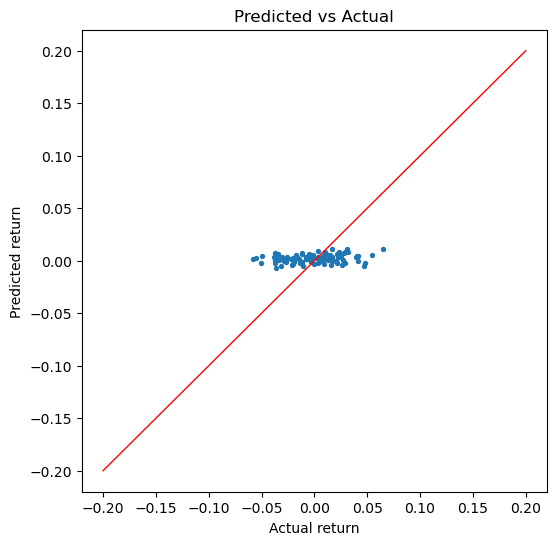

In [29]:

# Scatter predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=8)
plt.xlabel("Actual return"); plt.ylabel("Predicted return")
plt.title("Predicted vs Actual")
plt.plot([-0.2,0.2],[-0.2,0.2], color='red', linewidth=1)  # identity line
plt.show()
